In [1]:
!pip install deap bitarray lime

     |████████████████████████████████| 160 kB 5.4 MB/s 
     |████████████████████████████████| 88 kB 6.3 MB/s 
     |████████████████████████████████| 275 kB 33.0 MB/s 
  Created wheel for bitarray: filename=bitarray-2.3.4-cp37-cp37m-linux_x86_64.whl size=171949 sha256=15f729c1cce4844b294d0811be3e73ef8a1b7a07d83fc0eff4c699441e271058
  Stored in directory: /root/.cache/pip/wheels/84/cc/5b/0e861bdb5294d22d2d4f595df936f964a95258387e11494d41
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=3ac3387d4087a76f0a17d2a2ae2467f4bd549d981cb17506cc0027a91cb297b4
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built bitarray lime


In [4]:
!git clone https://github.com/rinziv/XAI_lib_HAI-net_Tutorial.git

Cloning into 'XAI_lib_HAI-net_Tutorial'...
remote: Enumerating objects: 321, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (264/264), done.
remote: Total 321 (delta 54), reused 312 (delta 45), pack-reused 0
Receiving objects: 100% (321/321), 198.69 MiB | 27.93 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Checking out files: 100% (274/274), done.


In [5]:
cd XAI_lib_HAI-net_Tutorial

/content/XAI_lib_HAI-net_Tutorial


# Examples of XAI-Lib Usage for IMAGENET

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
assert tf.__version__[0]=='2', 'please install tensorflow 2.x'

In [7]:
# Load data
imagenet_x_data = pickle.load(open('./datasets/imagenet.p','rb'))
imagenet_y_data = pickle.load(open('./datasets/imagenet_labels.p','rb'))
imagenet_map = pickle.load(open('./datasets/imagenet_mapping_labels.p','rb'))

# Load Model
imagenet_VGG = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=True,weights='imagenet')
imagenet_VGG.trainable = False
imagenet_VGG.summary()

553476096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [8]:
pred = np.argmax(imagenet_VGG(imagenet_x_data[0,:].reshape(1,224,224,3)).numpy())
pred

716

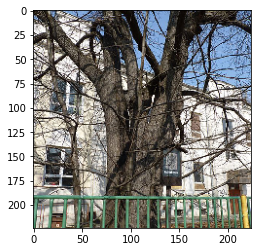

In [9]:
plt.imshow(imagenet_x_data[0,:].astype(int))

In [10]:
imagenet_map['716']

['n03930313', 'picket_fence']

## Intgrad

<img src='https://github.com/rinziv/XAI_lib_HAI-net_Tutorial/blob/main/images/intgrad_imagenet.jpg?raw=1' width="400" height="300">

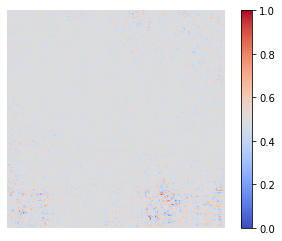

In [11]:
from xailib.explainers.intgrad_explainer import IntgradImageExplainer

# 1) Create the Explainer
ig = IntgradImageExplainer(imagenet_VGG)

# 2) Fit the Explainer
ig.fit()

# 3) Select the image we want to give an explanation for
image = imagenet_x_data[0,:]

# 4a) Preprocessing function: function that takes as input an image and return the correct format for the black box
def preprocessing(image):
    return tf.convert_to_tensor(image,dtype=tf.float32)

# 4b) Predict Function of our black box: It needs to take as input the output of preprocessing and return an array of probabilities of classes with shape (-1,num_classes)
def predict(image):
    return tf.nn.softmax(imagenet_VGG(image), axis=-1)

# 5) Explain an Instance
scores = ig.explain(image, 716, 'black', preprocessing, predict, model_type='tensorflow')

s = np.sum(scores,axis=-1)
plt.imshow((s+np.abs(np.min(s)))/(np.max(s)-np.min(s)),cmap='coolwarm')
plt.colorbar()
plt.axis('off');

# RISE

<img src='https://github.com/rinziv/XAI_lib_HAI-net_Tutorial/blob/main/images/rise_imagenet.jpg?raw=1' width="800" height="250">

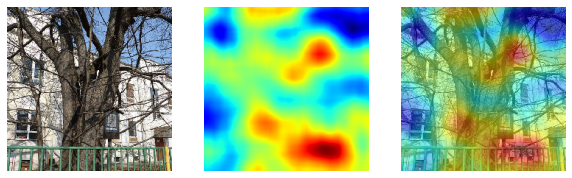

In [12]:
from xailib.explainers.rise_explainer import RiseXAIImageExplainer

class Rise_model_wrapper():
    def __init__(self, bb, input_size):
        self.model = bb
        self.input_size = input_size
        
    def predict(self, X):
        return self.model.predict(X)
        

model = Rise_model_wrapper(imagenet_VGG, (224,224))
rise = RiseXAIImageExplainer(model)
        
fig, ax = plt.subplots(1,3,figsize=(10,5))
img = imagenet_x_data[0,:]
N = 1000
s = 8
p1 = 0.5

rise.fit(N, s, p1)

sal = rise.explain(img)

ax[0].imshow(img/255,cmap='gray')
ax[0].axis('off')

ax[1].imshow(sal[pred],cmap='jet')
ax[1].axis('off')

ax[2].imshow(img/255,cmap='gray')
ax[2].imshow(sal[pred],cmap='jet',alpha=0.5)
ax[2].axis('off');

## LIME

<img src='https://github.com/rinziv/XAI_lib_HAI-net_Tutorial/blob/main/images/lime_imagenet.jpg?raw=1' width="800" height="250">

  0%|          | 0/500 [00:00<?, ?it/s]

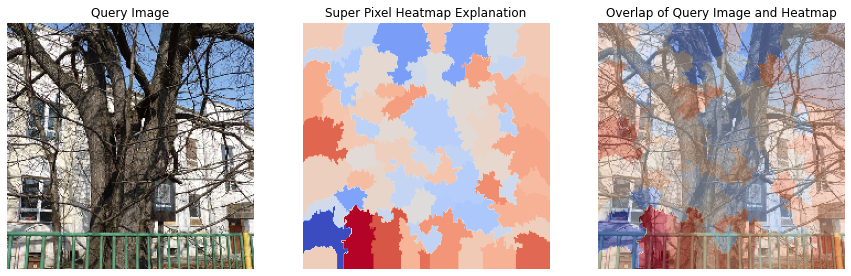

In [13]:
from xailib.explainers.lime_explainer import LimeXAIImageExplainer
from skimage.color import label2rgb

# index of the image to explain
idx = 0

# 1) Create the Explainer
lm = LimeXAIImageExplainer(imagenet_VGG)

# 2a) Fit the Explainer
lm.fit()

# 2b) Create custom classifier function if not predict 
# function that takes as input an array of images (the LIME neighbourhood) and return an array of (num_images,num_classes)
# If None will use black_box.predict function
def classifier_fn(images):
    images = images.astype(float)
    return np.argmax(imagenet_VGG.predict(images),axis=1).reshape(-1,1)

# 3) Explain an Instance
explanation = lm.explain(imagenet_x_data[idx].astype(int), classifier_fn, num_samples=500)

# 4) Plot the results
lm.plot_lime_values(imagenet_x_data[idx].astype(int), explanation)

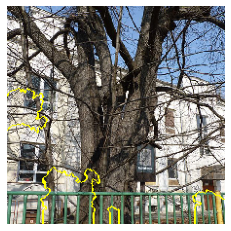

In [14]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)
plt.axis('off');

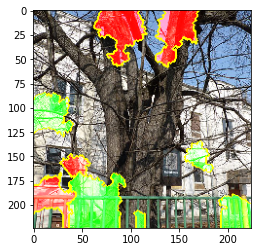

In [15]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2);

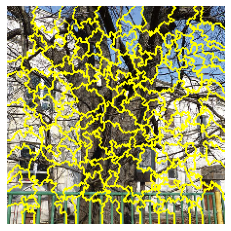

In [16]:
from skimage.segmentation import quickshift, mark_boundaries
from skimage.color import gray2rgb
image = imagenet_x_data[0].astype(int)
"""
First you need to define the segmentation function to use, in this example we will use
quickshift from skimage. It is foundamental to tune the parameters of the segmentation in
order to have a good one. It is recommentded to print an example of just only the segmentation
to see if it works for that kind of image
For quickshift we have to tune these two parameters below
kernel_size : float, optional
    Width of Gaussian kernel used in smoothing the
    sample density. Higher means fewer clusters.
max_dist : float, optional
    Cut-off point for data distances.
    Higher means fewer clusters.
"""
def segmentation_fn(image):
    return quickshift(image, kernel_size=3, max_dist=15)
plt.imshow(mark_boundaries(image/255,segmentation_fn(image)))
plt.axis('off');

  0%|          | 0/500 [00:00<?, ?it/s]

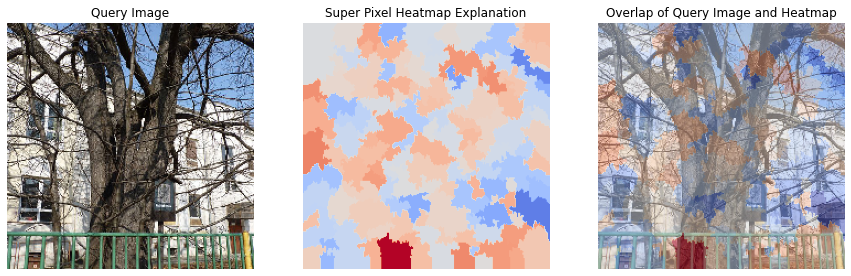

In [17]:
from xailib.explainers.lime_explainer import LimeXAIImageExplainer
from skimage.color import label2rgb

# index of the image to explain
idx = 0

# 1) Create the Explainer
lm = LimeXAIImageExplainer(imagenet_VGG)

# 2a) Fit the Explainer
lm.fit()

# 2b) Create custom classifier function if not predict 
# function that takes as input an array of images (the LIME neighbourhood) and return an array of (num_images,num_classes)
# If None will use black_box.predict function
def classifier_fn(images):
    images = images.astype(float)
    return np.argmax(imagenet_VGG.predict(images),axis=1).reshape(-1,1)

# 3) Explain an Instance
explanation = lm.explain(imagenet_x_data[idx].astype(int), classifier_fn, segmentation_fn, num_samples=500)

# 4) Plot the results
lm.plot_lime_values(imagenet_x_data[idx].astype(int), explanation)

# ILORE

<img src='https://github.com/rinziv/XAI_lib_HAI-net_Tutorial/blob/main/images/lore_imagenet.jpg?raw=1' width="500" height="250">

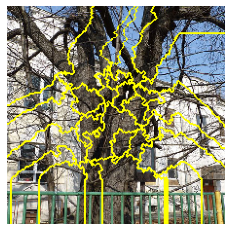

In [18]:
from skimage.segmentation import quickshift, mark_boundaries
from skimage.color import gray2rgb
image = imagenet_x_data[0].astype(int)
"""
First you need to define the segmentation function to use, in this example we will use
quickshift from skimage. It is foundamental to tune the parameters of the segmentation in
order to have a good one. It is recommentded to print an example of just only the segmentation
to see if it works for that kind of image
For quickshift we have to tune these two parameters below
kernel_size : float, optional
    Width of Gaussian kernel used in smoothing the
    sample density. Higher means fewer clusters.
max_dist : float, optional
    Cut-off point for data distances.
    Higher means fewer clusters.
"""
def segmentation_fn(image):
    return quickshift(image, kernel_size=15, max_dist=15)
plt.imshow(mark_boundaries(image/255,segmentation_fn(image)))
plt.axis('off');

In [19]:
from externals.LOREM.ilorem import ILOREM

# Predict Function of our black box. 
# !!!IMPORTANT!!! It needs to take as input a list of RGB images and return an array of class indices of shape (-1,1)
def classifier_fn(images):
    images = np.array(images,dtype=float)
    return np.argmax(imagenet_VGG(images).numpy(),axis=1).reshape(-1,1)

# Create the explainer
explainer = ILOREM(bb_predict = classifier_fn, 
                   class_name='class', 
                   class_values = range(1000), 
                   segmentation_fn=segmentation_fn,
                   verbose=True)

In [20]:
exp = explainer.explain_instance(imagenet_x_data[0,:].astype(int), num_samples=100, use_weights=True, metric='cosine')

generating neighborhood
synthetic neighborhood class counts {442: 1, 448: 1, 517: 36, 540: 6, 682: 1, 698: 2, 716: 16, 755: 35, 812: 2}
learning local decision tree
retrieving explanation


In [21]:
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.rstr(), exp.cstr()))

e = {
	r = { 4 > 0.50, 11 > 0.50, 3 > 0.50, 7 > 0.50, 22 > 0.50, 10 > 0.50, 2 > 0.50 } --> { class: 716 }
	c = { { 4 <= 0.50 } --> { class: 755 }, { 22 <= 0.50 } --> { class: 517 }, { 11 <= 0.50 } --> { class: 755 }, { 7 <= 0.50 } --> { class: 517 }, { 10 <= 0.50 } --> { class: 517 }, { 2 <= 0.50 } --> { class: 540 } }    
}


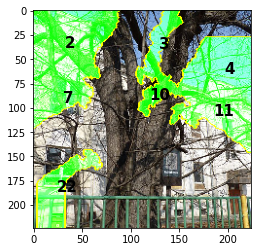

In [22]:
x,y = np.meshgrid(range(224),range(224))
img2show, mask = exp.get_image_rule(hide_rest=False, num_features=None, min_importance=0.0)
plt.imshow(mark_boundaries(img2show/255,mask))
mask[mask != 2] = -1
mask[mask == 2] = segmentation_fn(image)[mask == 2]

mask = mask.ravel()

for i in np.unique(mask):
    if i != -1:
        x_c = x.ravel()[np.where(mask==i)[0]]
        y_c = y.ravel()[np.where(mask==i)[0]]
        plt.text(np.median(x_c),np.median(y_c),str(i),fontsize=15, weight='bold')

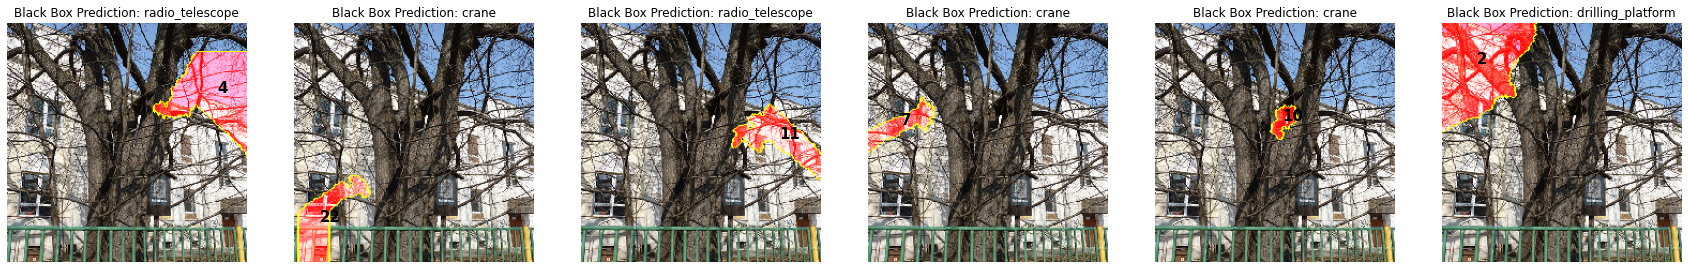

In [23]:
imgs2show, masks, coutcomes = exp.get_image_counterfactuals(hide_rest=False, num_features=None, min_importance=0.0)
x,y = np.meshgrid(range(224),range(224))
s = segmentation_fn(image)
if len(imgs2show)==1:
    plt.imshow(mark_boundaries(imgs2show[0]/255, masks[0]))
    plt.title('Black Box Prediction: '+str(coutcomes[0]))
    plt.axis('off')
else:
    F, ax = plt.subplots(1,len(imgs2show),figsize=(5*len(imgs2show),5))
    for i in range(len(imgs2show)):
        ax[i].imshow(mark_boundaries(imgs2show[i]/255, masks[i]))
        
        mask = masks[i]
        mask[mask != 1] = -1
        mask[mask == 1] = s[mask == 1]
        mask = mask.ravel()
        for j in np.unique(mask):
            if j != -1:
                x_c = x.ravel()[np.where(mask==j)[0]]
                y_c = y.ravel()[np.where(mask==j)[0]]
                ax[i].text(np.median(x_c),np.median(y_c),str(j),fontsize=15, weight='bold')
        
        ax[i].set_title('Black Box Prediction: '+imagenet_map[str(coutcomes[i])][1])
        ax[i].axis('off')